# Improved Arabic Sentiment Analysis with Logistic Regression

This notebook demonstrates an improved logistic regression pipeline for Arabic sentiment analysis. It reads an input CSV file containing tweets and labels, cleans and normalizes the text, handles negation phrases, extracts additional sentiment-related features, and trains a logistic regression classifier using TF-IDF vectors with uni-, bi- and trigrams plus the engineered features. It outputs model accuracy and F1 score.

> **Note:** Replace `'arabic_twitter_dataset_fixed.csv'` with your own CSV file name if needed. The CSV file should have two columns: `text` (the tweet) and `label` (`Positive` or `Negative`).


In [1]:
from google.colab import files
uploaded = files.upload()


Saving arabic_twitter_dataset_fixed.csv to arabic_twitter_dataset_fixed.csv


In [2]:

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack


POSITIVE_WORDS = {
    'رائع', 'ممتاز', 'جميل', 'حلو', 'عظيم', 'مبدع', 'جيد', 'احبه', 'احب',
    'سعيد', 'فرحان', 'مبسوط', 'حب', 'محبوب', 'متميز', 'افضل', 'الافضل',
    'نجح', 'نجاح', 'فوز', 'انتصار', 'قوي', 'مذهل', 'ولا اروع',

    'مش معقول', 'جامد', 'تحفه', 'خرافي', 'اسطوره', 'يجنن', 'يهبل',
    'ماشاءالله', 'بارك الله', 'الحمدلله', 'تمام', 'زي الفل'
}

NEGATIVE_WORDS = {
    'سيء', 'سئ', 'فظيع', 'مقرف', 'كريه', 'بشع', 'اكره', 'كره', 'حزين',
    'زعلان', 'مكتئب', 'فشل', 'خساره', 'ضعيف', 'رديء', 'اسوء', 'الاسوء',
    'مش حلو', 'وحش', 'غلط', 'خطأ', 'مشكله', 'مصيبه', 'كارثه',
    'للاسف', 'يا حسره', 'يا خساره', 'محزن', 'مؤلم', 'صعب'
}

NEGATION_WORDS = {'لا', 'ما', 'مش', 'ليس', 'لست', 'لن', 'لم', 'غير', 'بدون', 'من غير'}

def clean_text(text: str) -> str:
    '''Clean and normalize Arabic text by removing diacritics, normalizing letters and removing non-Arabic characters.'''
    text = str(text)
    text = re.sub(r'[ً-ٰٟ]', '', text)
    text = re.sub('[إأآا]', 'ا', text)
    text = text.replace('ى', 'ي')
    text = text.replace('ؤ', 'ء').replace('ئ', 'ء')
    text = text.replace('ة', 'ه')
    text = re.sub(r'[^؀-ۿ\s]', ' ', text)
    return text.strip()

def handle_negation(text: str) -> str:
    '''Add a NEG_ prefix to words following a negation word to help the model capture negated phrases.'''
    words = text.split()
    new_words = []
    negate = False
    count_after_neg = 0
    for word in words:
        if word in NEGATION_WORDS:
            negate = True
            count_after_neg = 0
            new_words.append(word)
        elif negate:
            new_words.append(f"NEG_{word}")
            count_after_neg += 1
            if count_after_neg >= 3:
                negate = False
        else:
            new_words.append(word)
    return ' '.join(new_words)

def extract_sentiment_features(text: str) -> dict:
    '''Extract additional sentiment-related features from text.'''
    words = text.split()
    pos_count = sum(1 for w in words if w in POSITIVE_WORDS)
    neg_count = sum(1 for w in words if w in NEGATIVE_WORDS)
    negation_count = sum(1 for w in words if w in NEGATION_WORDS)
    text_length = len(text)
    word_count = len(words)
    avg_word_length = np.mean([len(w) for w in words]) if words else 0
    exclamation_count = text.count('!')
    question_count = text.count('?')
    uppercase_ratio = sum(1 for c in text if c.isupper()) / len(text) if text else 0
    pos_neg_ratio = pos_count / neg_count if neg_count > 0 else pos_count
    return {
        'pos_word_count': pos_count,
        'neg_word_count': neg_count,
        'negation_count': negation_count,
        'text_length': text_length,
        'word_count': word_count,
        'avg_word_length': avg_word_length,
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'uppercase_ratio': uppercase_ratio,
        'pos_neg_ratio': pos_neg_ratio
    }


In [3]:

try:
    df = pd.read_csv('arabic_twitter_dataset_fixed.csv')
except FileNotFoundError:
    df = pd.read_csv('my_dataset.csv')

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

if 'label' in df.columns:
    df['label_id'] = df['label'].map({'Positive': 1, 'Negative': 0})

print('Cleaning and processing text...')
df['clean_text'] = df['text'].apply(clean_text)
df['negation_handled'] = df['clean_text'].apply(handle_negation)

df = df.dropna(subset=['negation_handled', 'label_id'])

feature_dicts = df['negation_handled'].apply(extract_sentiment_features)
feature_df = pd.DataFrame(list(feature_dicts))

# Display head of processed data
# print(df[['text', 'clean_text', 'negation_handled', 'label_id']].head())
# print(feature_df.head())
df.head()
# print(feature_df.head())


Cleaning and processing text...


,text,label,label_id,clean_text,negation_handled
0,ما أجمل الصبر و الإصرار,Positive,1,ما اجمل الصبر و الاصرار,ما NEG_اجمل NEG_الصبر NEG_و الاصرار
1,مبرد وجوهكم,Negative,0,مبرد وجوهكم,مبرد وجوهكم
2,فالأول يصحح مساري و الثاني يزيد من أصراري,Positive,1,فالاول يصحح مساري و الثاني يزيد من اصراري,فالاول يصحح مساري و الثاني يزيد من اصراري
3,فعلا احس في نفسي دللك,Positive,1,فعلا احس في نفسي دللك,فعلا احس في نفسي دللك
4,كلام جميل الكرامة أفضل و ابقى للإنسان,Positive,1,كلام جميل الكرامه افضل و ابقي للانسان,كلام جميل الكرامه افضل و ابقي للانسان


/tmp/ipython-input-3506366247.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label_id'].map({1: 'Positive', 0: 'Negative'}), palette='viridis')


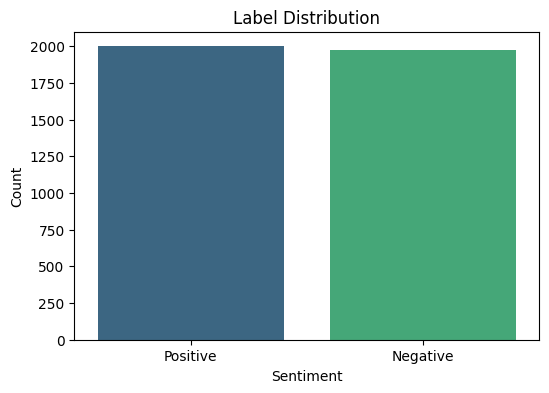

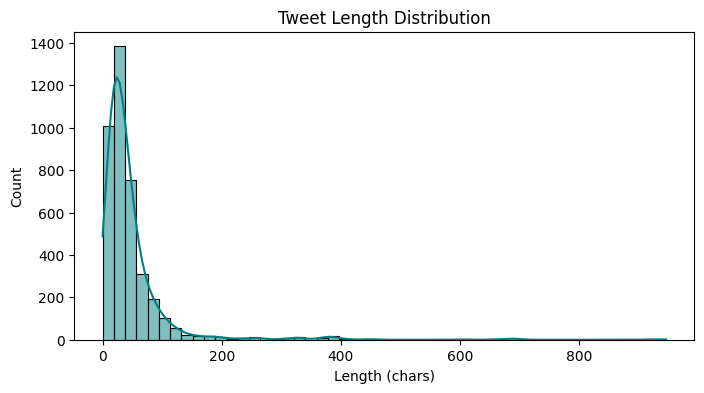

In [4]:

# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Label distribution plot
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label_id'].map({1: 'Positive', 0: 'Negative'}), palette='viridis')
plt.title('Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Tweet length distribution
df['text_len'] = df['clean_text'].apply(len)
plt.figure(figsize=(8, 4))
sns.histplot(df['text_len'], bins=50, color='teal', kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Length (chars)')
plt.show()


In [5]:

# Split data into train and test sets
X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    df['clean_text'], feature_df, df['label_id'], test_size=0.2, random_state=42, stratify=df['label_id']
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.8,
    sublinear_tf=True
)

X_train_tfidf = vectorizer.fit_transform(X_text_train)
X_test_tfidf = vectorizer.transform(X_text_test)

# Scale additional features
scaler = StandardScaler()
X_train_feat_scaled = scaler.fit_transform(X_feat_train)
X_test_feat_scaled = scaler.transform(X_feat_test)

# Combine TF-IDF and additional features
X_train_combined = hstack([X_train_tfidf, X_train_feat_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_feat_scaled])

# Train Logistic Regression classifier
clf = LogisticRegression(
    C=10,
    max_iter=1000,
    solver='liblinear',
    class_weight='balanced'
)

clf.fit(X_train_combined, y_train)
y_pred = clf.predict(X_test_combined)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Accuracy: 96.73%
F1-Score: 96.73%
Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.98      0.97       396
    Positive       0.98      0.96      0.97       400

    accuracy                           0.97       796
   macro avg       0.97      0.97      0.97       796
weighted avg       0.97      0.97      0.97       796



Accuracy: 96.73%
F1-Score: 96.73%
Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.98      0.97       396
    Positive       0.98      0.96      0.97       400

    accuracy                           0.97       796
   macro avg       0.97      0.97      0.97       796
weighted avg       0.97      0.97      0.97       796



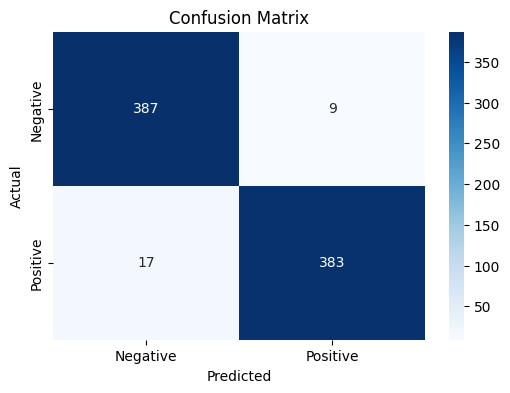

In [6]:
# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns



print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Negative','Positive']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [7]:
import joblib

joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')  # حفظ الـ TF‑IDF Vectorizer
joblib.dump(scaler, 'scaler.pkl')                # حفظ الـ StandardScaler
joblib.dump(clf, 'logistic_model.pkl')           # حفظ نموذج اللوجستيك ريجريشن


['logistic_model.pkl']